# dividends vs no-dividends

Compare SPY with and without dividends.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)                   
end = datetime.datetime.now()

Timeseries

In [4]:
# Fetch timeseries, select, finalize.
ts = pf.fetch_timeseries(symbol)
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)
ts, start = pf.finalize_timeseries(ts, start)

# Create tradelog and daily balance objects.
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [5]:
ts

,open,high,low,close,adj_close,volume
date,,,,,,
1993-01-29,24.70,24.70,24.58,24.68,24.68,1003200
1993-02-01,24.70,24.86,24.70,24.86,24.86,480500
1993-02-02,24.84,24.93,24.79,24.91,24.91,201300
1993-02-03,24.95,25.19,24.93,25.18,25.18,529400
1993-02-04,25.26,25.33,24.98,25.28,25.28,531500
...,...,...,...,...,...,...
2024-08-14,542.85,544.96,540.12,543.75,543.75,42446900
2024-08-15,549.50,553.36,548.88,553.07,553.07,60846800
2024-08-16,551.42,555.02,551.26,554.31,554.31,44430700


Algorithm

In [6]:
pf.TradeLog.cash = capital

# Loop through timeseries.
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # Buy.
    if tlog.shares == 0:
        tlog.buy(date, row.close)
    # Sell.
    elif end_flag:
        tlog.sell(date, row.close)

    # Record daily balance.
    dbal.append(date, row.close)

Retrieve logs and get stats

In [7]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)
stats = pf.stats(ts, tlog, dbal, capital)

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=False)
benchmark.run()

Plot Equity Curves: Dividends (strategy) vs No-Dividends (benchmark)

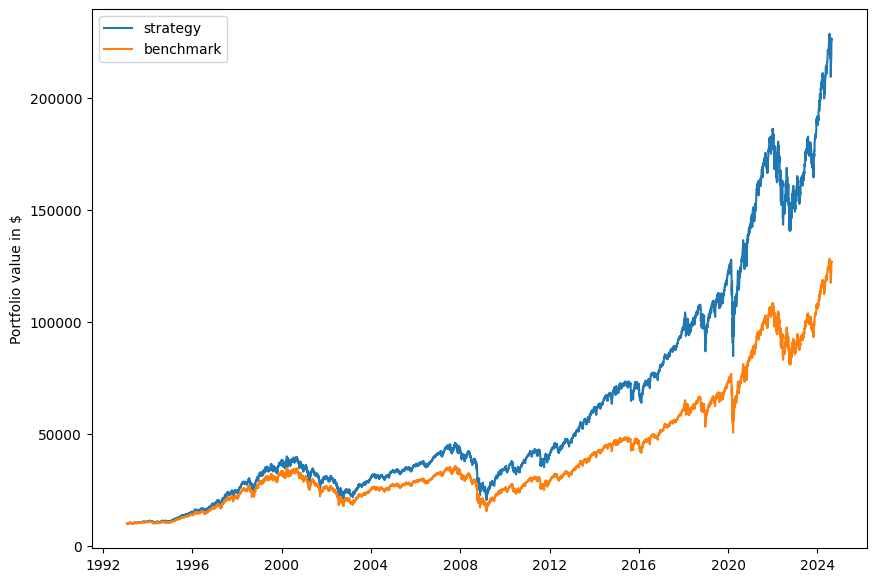

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal, fname='equity_curve.png')

Dividends (strategy) vs No-Dividends (benchmark)

In [10]:
pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$226,276.44","$126,851.09"
total_net_profit,"$216,276.44","$116,851.09"
gross_profit,"$216,276.44","$116,851.09"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,10.39,8.38
max_closed_out_drawdown,-55.19,-56.43
annualized_return_over_max_drawdown,0.19,0.15
best_month,23.62,23.06
worst_month,-30.99,-31.38
sharpe_ratio,0.62,0.52
sortino_ratio,0.80,0.67
monthly_std,4.46,4.46
annual_std,16.98,16.65
avg_month,0.88,0.73


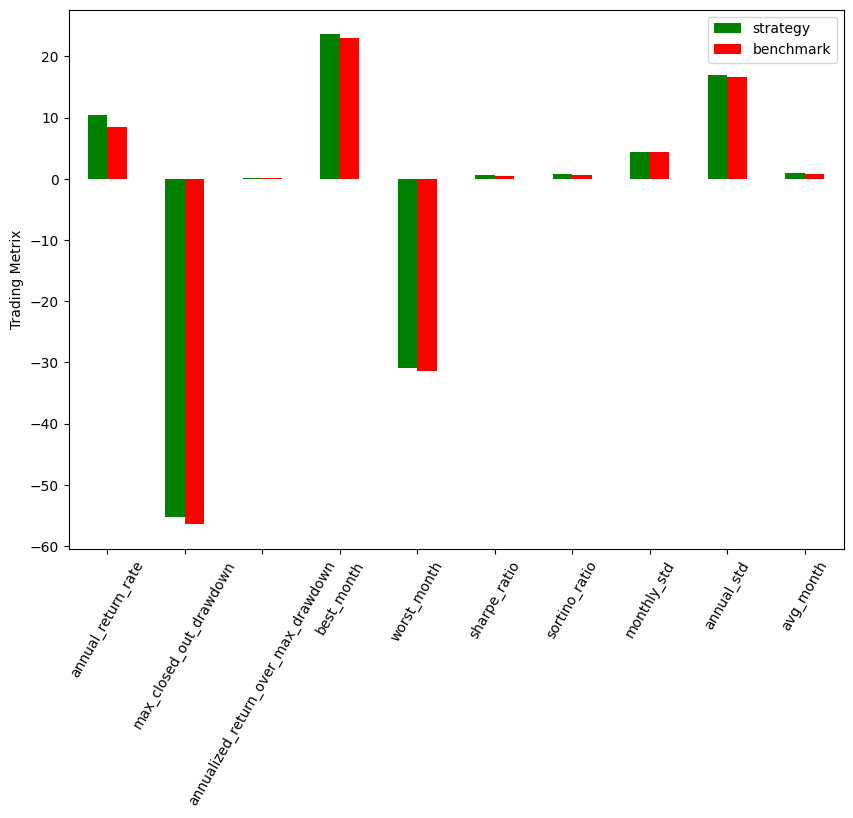

In [11]:
pf.plot_bar_graph(stats, benchmark.stats, extras=('avg_month',))